In [1]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
output_folder = 'output_control'
nmda = h5py.File('./{}/inmda_report.h5'.format(output_folder),'r')
v = h5py.File('./{}/v_report.h5'.format(output_folder),'r')
hva = h5py.File('./{}/Ca_HVA.ica_report.h5'.format(output_folder),'r')
lva = h5py.File('./{}/Ca_LVAst.ica_report.h5'.format(output_folder),'r')
ih = h5py.File('./{}/Ih.ihcn_report.h5'.format(output_folder),'r')
na = h5py.File('./{}/NaTa_t.gNaTa_t_report.h5'.format(output_folder),'r')

spks = h5py.File('./{}/spikes.h5'.format(output_folder),'r')
spktimes = spks['spikes']['biophysical']['timestamps'][:]
spkinds = np.sort((spktimes*10).astype(int))

In [3]:
segs = pd.read_csv('/Volumes/TOSHIBA EXT/L5NeuronSimulation_new/L5NeuronSimulation/MorphAnalysis/Segments.csv')
segs_degrees = pd.read_csv('SegmentsDegrees.csv').groupby(['Type','Sec ID'])['Degrees'].max().reset_index()
segs['segmentID'] = segs.index
segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()

segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'

segs.loc[segs.Type=='dend','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False)
segs.loc[segs.Type=='apic','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False)

In [5]:
na_df = pd.read_csv('na_df.csv')

In [5]:
for i in np.random.choice(na_df[(na_df.na_lower_bound>20) & (na_df.na_lower_bound<1400000)].index,10000):
    seg = na_df.loc[i,'segmentID']
    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
        spkt = int(na_df.loc[i,'na_lower_bound'])
        trace = na['report']['biophysical']['data'][spkt-10:spkt+10,seg]
        peak_value = np.max(trace)
        half_peak = peak_value/2
        duration = np.arange(0,20)[trace>half_peak] + spkt - 10
        na_df.loc[i,'duration_low'] = duration[0]
        na_df.loc[i,'duration_high'] = duration[-1]
        na_df.loc[i,'peak_value'] = peak_value
    else:
        na_df.loc[i,'duration_low'] = np.nan
        na_df.loc[i,'duration_high'] = np.nan
        na_df.loc[i,'peak_value'] = np.nan
        
na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

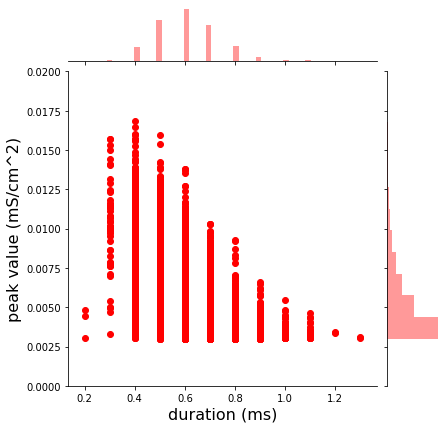

In [6]:
h = sns.jointplot(data=na_df[~pd.isnull(na_df.duration_low)], x="duration", y="peak_value",color='red')
h.set_axis_labels('duration (ms)', 'peak value (mS/cm^2)', fontsize=16)
h.ax_marg_y.set_ylim(0, 0.02)
plt.savefig('na_df.svg')

In [8]:
na_df_bin = na_df[~pd.isnull(na_df.duration_low)].reset_index(drop=True)

na_df_bin['duration_bin'] = pd.cut(na_df_bin['duration'], bins = np.arange(0.15,1.05,0.1), labels=False)
na_df_bin['mag_bin'] = pd.cut(na_df_bin['peak_value'], bins = 2*np.logspace(-3,-2,num=15), labels=False)

na_df_gb = na_df_bin.groupby(['duration_bin','mag_bin'])['duration'].count().reset_index()

na_df_imhist = np.zeros((15,15))
for i in np.arange(0,15):
    for j in np.arange(0,15):
        try:
            na_df_imhist[i,j] = na_df_gb[(na_df_gb.duration_bin==j) & (na_df_gb.mag_bin==i)]['duration']
        except:
            na_df_imhist[i,j] = 0
            
plt.imshow(100 * na_df_imhist / na_df_imhist.sum(), origin = 'lower')
plt.xlabel('duration (ms)', fontsize = 16)
plt.ylabel('magnitude (mS/cm^2)', fontsize = 16)
plt.xticks(ticks = [0,4,8,12], labels = [0.15, 0.55, 0.95, 1.35])
#plt.yticks(ticks = [0,4,8,12], labels = [2e-3, 0.00386, 0.00746, 0.0144])
plt.colorbar(label='% of events')
plt.savefig('naspkdurations.svg')
#plt.xlim(0,10)
plt.show()

In [6]:
seg_na_df = na_df.groupby('segmentID')['na_lower_bound'].count().reset_index().rename(columns={'na_lower_bound':'num_na_spikes'})
segs_na_df = segs.set_index('segmentID').join(seg_na_df.set_index('segmentID'))
segs_na_df.loc[segs_na_df.num_na_spikes>1000,'num_na_spikes'] = 1000

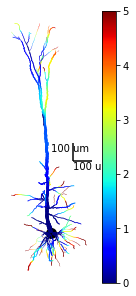

In [8]:
color_field = 'num_na_spikes'

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 5)

for i in segs_na_df[segs_na_df.Type=='apic']['Sec ID'].unique():
    section = segs_na_df[(segs_na_df.Type=='apic')&(segs_na_df['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(section.loc[j:j+1,color_field].mean()/150)),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
    
for i in segs_na_df[segs_na_df.Type=='dend']['Sec ID'].unique():
    section = segs_na_df[(segs_na_df.Type=='dend')&(segs_na_df['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(section.loc[j:j+1,color_field].mean()/150)),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
        
plt.scatter(segs_na_df[(segs_na_df.Type=='soma')&(segs_na_df['Sec ID']==0)].loc[2,'Coord X'],
         segs_na_df[(segs_na_df.Type=='soma')&(segs_na_df['Sec ID']==0)].loc[2,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('na_spk_segments.svg')

# NMDA

In [38]:
nmda_df = pd.read_csv('nmda_df.csv')

In [39]:
nmda_df['duration'] = (nmda_df['nmda_upper_bound'] - nmda_df['nmda_lower_bound'])/10

In [40]:
nmda_df['log_duration'] = np.log(nmda_df['duration'])
nmda_df['log_mag'] = np.log(np.abs(nmda_df['mag']))

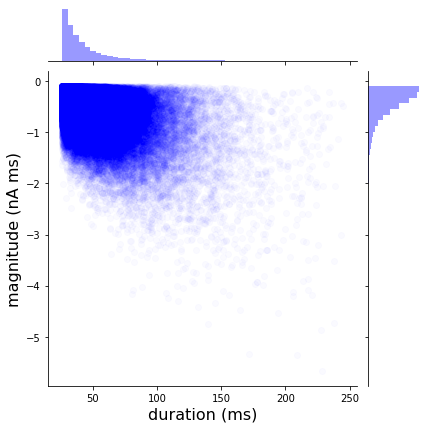

In [41]:
h = sns.jointplot(data=nmda_df[(nmda_df.mag<-0.1)&
                               (nmda_df.duration<250)&
                               (nmda_df.duration>26)], x="duration", y="mag",alpha=0.02, color='blue')
h.set_axis_labels('duration (ms)', 'magnitude (nA ms)', fontsize=16)
plt.savefig('nmda_df.svg')

In [42]:
nmda_df_bin = nmda_df[(nmda_df.mag<-0.1)&(nmda_df.duration<250)&(nmda_df.duration>26)].copy()

nmda_df_bin['duration_bin'] = pd.cut(nmda_df_bin['duration'], bins = 2*np.logspace(1.1,1.8,num=15), labels=False)
nmda_df_bin['mag_bin'] = pd.cut(-nmda_df_bin['mag'], bins = np.logspace(-1,0.5,num=15), labels=False)

nmda_df_gb = nmda_df_bin.groupby(['duration_bin','mag_bin'])['duration'].count().reset_index()

nmda_df_imhist = np.zeros((15,15))
for i in np.arange(0,15):
    for j in np.arange(0,15):
        try:
            nmda_df_imhist[i,j] = nmda_df_gb[(nmda_df_gb.duration_bin==j) & (nmda_df_gb.mag_bin==i)]['duration']
        except:
            nmda_df_imhist[i,j] = 0

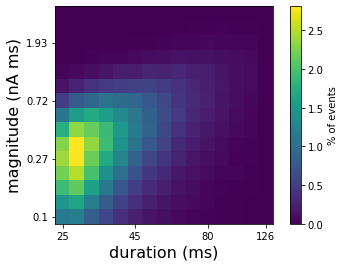

In [74]:
plt.imshow(100 * nmda_df_imhist / nmda_df_imhist.sum(), origin = 'lower')
plt.xlabel('duration (ms)', fontsize = 16)
plt.ylabel('magnitude (nA ms)', fontsize = 16)
plt.xticks(ticks = [0,5,10,14], labels = [25, 45, 80, 126])
plt.yticks(ticks = [0,4,8,12], labels = [0.10, 0.27, 0.72, 1.93])
plt.colorbar(label='% of events')
plt.savefig('nmdaspkdurations.svg')
plt.show()

In [44]:
seg_nmda_df = nmda_df.groupby('segmentID')['nmda_lower_bound'].count().reset_index().rename(columns={'nmda_lower_bound':'num_nmda_spikes'})

segs_nmda_df = segs.set_index('segmentID').join(seg_nmda_df.set_index('segmentID'))


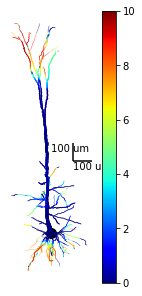

In [77]:
color_field = 'num_nmda_spikes'

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 10)

for i in segs_nmda_df[segs_nmda_df.Type=='apic']['Sec ID'].unique():
    section = segs_nmda_df[(segs_nmda_df.Type=='apic')&(segs_nmda_df['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(section.loc[j:j+1,color_field].mean()/150)),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
    
for i in segs_nmda_df[segs_nmda_df.Type=='dend']['Sec ID'].unique():
    section = segs_nmda_df[(segs_nmda_df.Type=='dend')&(segs_nmda_df['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(section.loc[j:j+1,color_field].mean()/150)),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
        
plt.scatter(segs_nmda_df[(segs_nmda_df.Type=='soma')&(segs_nmda_df['Sec ID']==0)].loc[2,'Coord X'],
         segs_nmda_df[(segs_nmda_df.Type=='soma')&(segs_nmda_df['Sec ID']==0)].loc[2,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('nmda_spk_segments.svg')

# Ca

In [4]:
ca_df = pd.read_csv('ca_df.csv')

In [5]:
ca_df['dist_from_soma_spike'] = ca_df['ca_lower_bound'].apply(lambda x: np.min(np.abs(x-spkinds)))
ca_df['duration'] = (ca_df['ca_upper_bound'] - ca_df['ca_lower_bound'])/10
ca_df['mag_dur'] = ca_df['mag']/ca_df['duration']

In [6]:
ca_df = ca_df[(ca_df.mag<-0.1)&
                           (ca_df.duration<250)&
                           (ca_df.duration>26)&
                           (ca_df.dist_from_soma_spike>50)&
                           (ca_df.mag_dur<-0.006)]

In [7]:
ca_df_bin = ca_df[(ca_df.mag<-0.1)&
                           (ca_df.duration<250)&
                           (ca_df.duration>26)&
                           (ca_df.dist_from_soma_spike>50)&
                           (ca_df.mag_dur<-0.006)].copy()

ca_df_bin['duration_bin'] = pd.cut(ca_df_bin['duration'], bins = 2*np.logspace(1.1,1.5,num=15), labels=False)
ca_df_bin['mag_bin'] = pd.cut(-ca_df_bin['mag'], bins = np.linspace(0.1,1.4,num=15), labels=False)

ca_df_gb = ca_df_bin.groupby(['duration_bin','mag_bin'])['duration'].count().reset_index()

ca_df_imhist = np.zeros((15,15))
for i in np.arange(0,15):
    for j in np.arange(0,15):
        try:
            ca_df_imhist[i,j] = ca_df_gb[(ca_df_gb.duration_bin==j) & (ca_df_gb.mag_bin==i)]['duration']
        except:
            ca_df_imhist[i,j] = 0

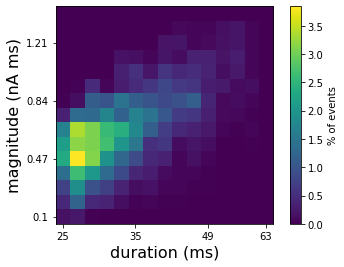

In [9]:
plt.imshow(100 * ca_df_imhist / ca_df_imhist.sum(), origin = 'lower')
plt.xlabel('duration (ms)', fontsize = 16)
plt.ylabel('magnitude (nA ms)', fontsize = 16)
plt.xticks(ticks = [0,5,10,14], labels = [25, 35, 49, 63])
plt.yticks(ticks = [0,4,8,12], labels = [0.10, 0.47, 0.84, 1.21])
plt.colorbar(label='% of events')
plt.savefig('caspkdurations.svg')
plt.show()

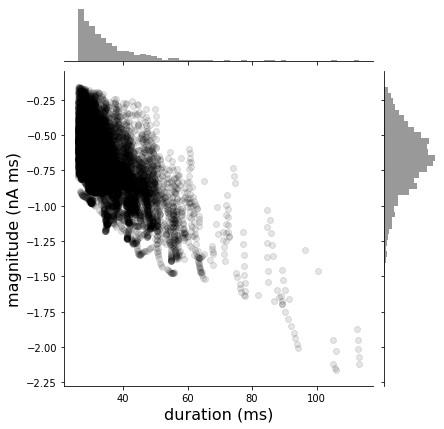

In [10]:
h = sns.jointplot(data=ca_df, x="duration", y="mag",alpha=0.1, color='black')
h.set_axis_labels('duration (ms)', 'magnitude (nA ms)', fontsize=16)
plt.savefig('ca_df.svg')

In [11]:
ca_df = ca_df[(ca_df.mag<-0.1)&
                           (ca_df.duration<250)&
                           (ca_df.duration>26)&
                           (ca_df.dist_from_soma_spike>50)]

seg_ca_df = ca_df.groupby('segmentID')['ca_lower_bound'].count().reset_index().rename(columns={'ca_lower_bound':'num_ca_spikes'})

segs_ca_df = segs.set_index('segmentID').join(seg_ca_df.set_index('segmentID')).reset_index()


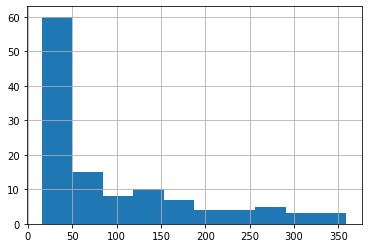

In [12]:
segs_ca_df['num_ca_spikes'].hist()

In [14]:
segs_ca_df_plot = segs_ca_df.copy()
#segs_ca_df_plot.loc[(segs_ca_df_plot['Coord Y']<630)|(segs_ca_df_plot['Coord Y']>830),'num_ca_spikes'] = 0

In [15]:
segs_ca_df[(segs_ca_df.HVA_gbar>0.0004)&(segs_ca_df.Type=='apic')]['Coord Y'].min()

nan

In [16]:
segs_ca_df[(segs_ca_df.HVA_gbar>0.0004)&(segs_ca_df.Type=='apic')]['Coord Y'].max()

nan

In [17]:
segs_ca_df_plot[(segs_ca_df_plot.Type=='soma')&(segs_ca_df_plot['Sec ID']==0)]

,segmentID,Type,Sec ID,BMTK ID,X,Distance,Section_L,Section_diam,Coord X,Coord Y,Coord Z,Elec_distance,Elec_distance_nexus,HVA_gbar,Degrees,Elec_distanceQ,num_ca_spikes
2521,0,soma,0,0,0.1,2.316936,23.169362,17.526643,-9.249733,-0.577674,0.0,0.997705,0.198622,0.0,0,None,NaN
2522,1,soma,0,0,0.3,6.950809,23.169362,17.526643,-4.624868,-0.288877,0.0,0.999137,0.198907,0.0,0,None,NaN
2523,2,soma,0,0,0.5,11.584681,23.169362,17.526643,-0.000010,0.000021,0.0,1.000000,0.199079,0.0,0,None,NaN
2524,3,soma,0,0,0.7,16.218553,23.169362,17.526643,4.624854,0.288824,0.0,0.999154,0.198911,0.0,0,None,NaN
2525,4,soma,0,0,0.9,20.852426,23.169362,17.526643,9.249712,0.577722,0.0,0.997674,0.198616,0.0,0,None,NaN


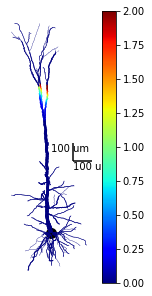

In [18]:
color_field = 'num_ca_spikes'

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 2)

for i in segs_ca_df_plot[segs_ca_df_plot.Type=='apic']['Sec ID'].unique():
    section = segs_ca_df_plot[(segs_ca_df_plot.Type=='apic')&(segs_ca_df_plot['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(section.loc[j:j+1,color_field].mean()/150)),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
    
for i in segs_ca_df_plot[segs_ca_df_plot.Type=='dend']['Sec ID'].unique():
    section = segs_ca_df_plot[(segs_ca_df_plot.Type=='dend')&(segs_ca_df_plot['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(section.loc[j:j+1,color_field].mean()/150)),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
        
plt.scatter(segs_ca_df_plot[(segs_ca_df_plot.Type=='soma')&(segs_ca_df_plot['Sec ID']==0)].loc[2523,'Coord X'],
         segs_ca_df_plot[(segs_ca_df_plot.Type=='soma')&(segs_ca_df_plot['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('ca_spk_segments.svg')

In [155]:
segs_lt = ca_df[(ca_df.duration<50) & (ca_df.mag<-0.5) & (ca_df.dist_from_soma_spike>50) & (ca_df.mag_dur<-0.006)]['segmentID'].unique()
segs_gt = ca_df[(ca_df.duration<50) & (ca_df.mag<-0.5) & (ca_df.dist_from_soma_spike>50) & (ca_df.mag_dur>-0.006)]['segmentID'].unique()

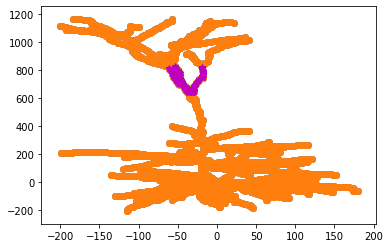

In [157]:
plt.scatter(segs['Coord X'], segs['Coord Y'])
plt.plot(segs.loc[segs.segmentID.isin(segs_lt),'Coord X'],segs.loc[segs.segmentID.isin(segs_lt),'Coord Y'],'m*')
plt.scatter(segs['Coord X'], segs['Coord Y'])
plt.plot(segs.loc[segs.segmentID.isin(segs_gt),'Coord X'],segs.loc[segs.segmentID.isin(segs_gt),'Coord Y'],'r*')

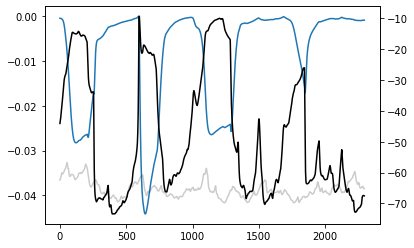

In [115]:
seg = 1852
low = 1461407
high = 1461703
plt.plot(hva['report']['biophysical']['data'][low-1000:high+1000,seg]+\
         lva['report']['biophysical']['data'][low-1000:high+1000,seg]+\
         ih['report']['biophysical']['data'][low-1000:high+1000,seg])
plt.twinx()
plt.plot(v['report']['biophysical']['data'][low-1000:high+1000,seg],color='k')
plt.plot(v['report']['biophysical']['data'][low-1000:high+1000,0],color='k',alpha=0.2)

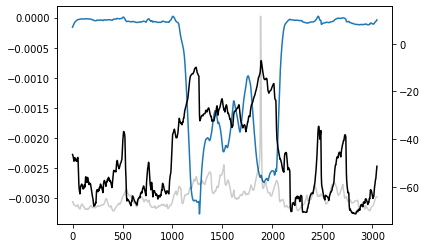

In [91]:
plt.plot(hva['report']['biophysical']['data'][162647-1000:163693+1000,1070]+\
         lva['report']['biophysical']['data'][162647-1000:163693+1000,1070]+\
         ih['report']['biophysical']['data'][162647-1000:163693+1000,1070])
plt.twinx()
plt.plot(v['report']['biophysical']['data'][162647-1000:163693+1000,1070],color='k')
plt.plot(v['report']['biophysical']['data'][162647-1000:163693+1000,0],color='k',alpha=0.2)

In [462]:
from functools import partial
import scipy.stats as st

levy_dist = partial(st.levy_stable.rvs, alpha=1.37, beta=-1.00, loc=0.92, scale=0.44, size=1)
levy_dist2 = partial(st.levy_stable.rvs, alpha=1.37, beta=-1.00, loc=0.92/2, scale=0.44, size=1)
levy_dist3 = partial(st.levy_stable.rvs, alpha=1.37, beta=-1.00, loc=0.92/10, scale=0.44, size=1)

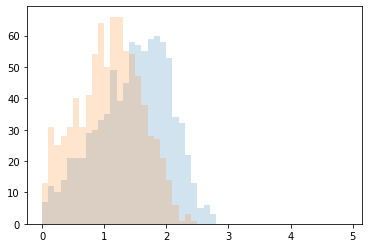

In [465]:
x = levy_dist(size=1000)
x[x<0] = 0
plt.hist(x[x>0],bins=np.arange(0,5,.1),alpha=0.2)
x = levy_dist2(size=1000)
x[x<0] = 0
plt.hist(x[x>0],bins=np.arange(0,5,.1),alpha=0.2)
#x = levy_dist3(size=1000)
#x[x<0] = 0
#plt.hist(x[x>0],bins=np.arange(0,5,.1),alpha=0.2)
plt.show()

In [415]:
f = h5py.File('exc_stim_spikes_control.h5','r')

In [416]:
from raster_maker import SonataWriter

In [417]:
df = pd.DataFrame(np.concatenate((f['spikes']['exc_stim']['node_ids'][:].reshape(-1,1),
                             f['spikes']['exc_stim']['timestamps'][:].reshape(-1,1)),axis=1),
                  columns=['node_id','timestamps'])

In [418]:
fname = 'exc_stim_spikes_50p.h5'
writer = SonataWriter(fname, ["spikes", "exc_stim"], ["timestamps", "node_ids"], [np.float, np.int])

for i in np.unique(f['spikes']['exc_stim']['node_ids'][:]):
    #import pdb; pdb.set_trace()
    ts = df.loc[df.node_id==i,'timestamps'].values
    ts_redux = np.random.choice(ts,int(ts.shape[0]*0.5))
    if len(ts_redux)==0:
        ts_redux = ts
    writer.append_repeat("node_ids", i + 0, len(ts_redux))
    writer.append_ds(ts_redux + 0, "timestamps")

In [419]:
writer.close()

In [427]:
f = h5py.File('exc_stim_spikes_control.h5','r')
ex = h5py.File('exc_stim_spikes.h5','r')

In [428]:
df = pd.DataFrame(np.concatenate((f['spikes']['exc_stim']['node_ids'][:].reshape(-1,1), 
                                  f['spikes']['exc_stim']['timestamps'][:].reshape(-1,1)),axis=1),
                  columns=['node_ids','timestamps'])

df2 = pd.DataFrame(np.concatenate((ex['spikes']['exc_stim']['node_ids'][:].reshape(-1,1), 
                                  ex['spikes']['exc_stim']['timestamps'][:].reshape(-1,1)),axis=1),
                  columns=['node_ids','timestamps'])


In [429]:
df2[df2.node_ids==5135].shape

(49, 2)

In [430]:
df[df.node_ids==5135].shape

(99, 2)

In [436]:
f['spikes']['exc_stim']['node_ids'], f['spikes']['exc_stim']['timestamps']

(<HDF5 dataset "node_ids": shape (713312,), type "<i8">,
 <HDF5 dataset "timestamps": shape (713312,), type "<f8">)

In [437]:
ex['spikes']['exc_stim']['node_ids'], ex['spikes']['exc_stim']['timestamps']

(<HDF5 dataset "node_ids": shape (355397,), type "<i8">,
 <HDF5 dataset "timestamps": shape (355397,), type "<f8">)

In [357]:
fname = 'exc_stim_spikes_150p.h5'
writer = SonataWriter(fname, ["spikes", "exc_stim"], ["timestamps", "node_ids"], [np.float, np.int])

for i in np.arange(0,np.unique(f['spikes']['exc_stim']['node_ids'][:]).shape[0]):
    ts = df.loc[df.node_id==i,'timestamps'].values
    extras = np.random.choice(ts,int(ts.shape[0]*0.5)) + np.random.uniform(low=-10,high=10,size=int(ts.shape[0]*0.5))
    ts_redux = np.concatenate((ts,extras))

    writer.append_repeat("node_ids", i + 0, len(ts_redux))
    writer.append_ds(ts_redux + 0, "timestamps")
    

In [363]:
f50 = h5py.File('exc_stim_spikes_50p.h5','r')
f150 = h5py.File('exc_stim_spikes_150p.h5','r')

In [364]:
np.median(pd.DataFrame(f['spikes']['exc_stim']['node_ids'][:])[0].value_counts().values/30)

4.333333333333333

In [365]:
np.median(pd.DataFrame(f50['spikes']['exc_stim']['node_ids'][:])[0].value_counts().values/30)

2.1666666666666665

In [366]:
np.median(pd.DataFrame(f150['spikes']['exc_stim']['node_ids'][:])[0].value_counts().values/30)

6.5

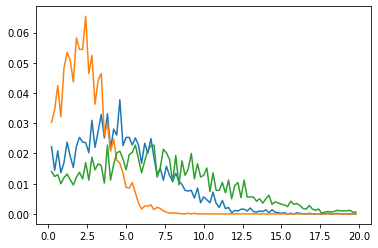

In [368]:
y,e = np.histogram(pd.DataFrame(f['spikes']['exc_stim']['node_ids'][:])[0].value_counts().values/30,
         bins=np.arange(0,20,0.2))
plt.plot(e[1:],y/np.sum(y))
y,e = np.histogram(pd.DataFrame(f50['spikes']['exc_stim']['node_ids'][:])[0].value_counts().values/30,
         bins=np.arange(0,20,0.2))
plt.plot(e[1:],y/np.sum(y))
y,e = np.histogram(pd.DataFrame(f150['spikes']['exc_stim']['node_ids'][:])[0].value_counts().values/30,
         bins=np.arange(0,20,0.2))
plt.plot(e[1:],y/np.sum(y))
plt.show()

In [347]:
f = h5py.File('./output/spikes.h5','r')
g = h5py.File('./output_control/spikes.h5','r')

In [348]:
f['spikes']['biophysical']['timestamps'][0:10], g['spikes']['biophysical']['timestamps'][0:10]

(array([4.00000e+00, 9.63089e+04, 9.63163e+04, 9.63235e+04, 9.72523e+04,
        9.72585e+04, 9.74758e+04, 9.76168e+04, 9.77256e+04, 9.79906e+04]),
 array([4.00000e+00, 9.63089e+04, 9.63163e+04, 9.63235e+04, 9.72523e+04,
        9.72585e+04, 9.74758e+04, 9.76168e+04, 9.77256e+04, 9.79906e+04]))

In [369]:
f = h5py.File('exc_stim_spikes.h5','r')

In [375]:
f['spikes']['exc_stim']['node_ids'], f['spikes']['exc_stim']['timestamps']

(<HDF5 dataset "node_ids": shape (350277,), type "<i8">,
 <HDF5 dataset "timestamps": shape (350277,), type "<f8">)

In [376]:
g = h5py.File('exc_stim_spikes_control.h5','r')

In [377]:
g['spikes']['exc_stim']['node_ids'], g['spikes']['exc_stim']['timestamps']

(<HDF5 dataset "node_ids": shape (713312,), type "<i8">,
 <HDF5 dataset "timestamps": shape (713312,), type "<f8">)

In [379]:
np.unique(g['spikes']['exc_stim']['node_ids'][:])

array([   0,    1,    2, ..., 5219, 5220, 5221])

In [380]:
np.unique(f['spikes']['exc_stim']['node_ids'][:])

array([   0,    1,    2, ..., 5132, 5133, 5134])

In [500]:
f = h5py.File('./output_low/exc_stim_spikes.h5','r')
g = h5py.File('./output_lowmed/exc_stim_spikes.h5','r')
h = h5py.File('./output_med/exc_stim_spikes.h5','r')
i = h5py.File('./output_medhigh/exc_stim_spikes.h5','r')
j = h5py.File('./output_high/exc_stim_spikes.h5','r')

fo = h5py.File('./output_low/spikes.h5','r')
go = h5py.File('./output_lowmed/spikes.h5','r')
ho = h5py.File('./output_med/spikes.h5','r')
io = h5py.File('./output_medhigh/spikes.h5','r')
jo = h5py.File('./output_high/spikes.h5','r')

In [501]:
fo['spikes']['biophysical']['timestamps'][:].shape[0]/30

0.5

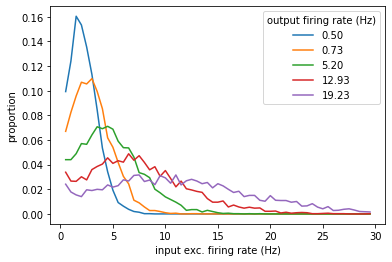

In [508]:
df = pd.DataFrame(f['spikes']['exc_stim']['node_ids'][:],columns=['node_ids'])
y,_ = np.histogram(df['node_ids'].value_counts().values/30,bins=np.arange(0,30,0.5))
plt.plot(np.arange(0,30,0.5)[1:],
         y/np.sum(y),
         label='{x:0.2f}'.format(x=fo['spikes']['biophysical']['timestamps'][:].shape[0]/30))

df = pd.DataFrame(g['spikes']['exc_stim']['node_ids'][:],columns=['node_ids'])
y,_ = np.histogram(df['node_ids'].value_counts().values/30,bins=np.arange(0,30,0.5))
plt.plot(np.arange(0,30,0.5)[1:],
         y/np.sum(y),
         label='{x:0.2f}'.format(x=go['spikes']['biophysical']['timestamps'][:].shape[0]/30))

df = pd.DataFrame(h['spikes']['exc_stim']['node_ids'][:],columns=['node_ids'])
y,_ = np.histogram(df['node_ids'].value_counts().values/30,bins=np.arange(0,30,0.5))
plt.plot(np.arange(0,30,0.5)[1:],
         y/np.sum(y),
         label='{x:0.2f}'.format(x=ho['spikes']['biophysical']['timestamps'][:].shape[0]/30))

df = pd.DataFrame(i['spikes']['exc_stim']['node_ids'][:],columns=['node_ids'])
y,_ = np.histogram(df['node_ids'].value_counts().values/30,bins=np.arange(0,30,0.5))
plt.plot(np.arange(0,30,0.5)[1:],
         y/np.sum(y),
         label='{x:0.2f}'.format(x=io['spikes']['biophysical']['timestamps'][:].shape[0]/30))

df = pd.DataFrame(j['spikes']['exc_stim']['node_ids'][:],columns=['node_ids'])
y,_ = np.histogram(df['node_ids'].value_counts().values/30,bins=np.arange(0,30,0.5))
plt.plot(np.arange(0,30,0.5)[1:],
         y/np.sum(y),
         label='{x:0.2f}'.format(x=jo['spikes']['biophysical']['timestamps'][:].shape[0]/30))

plt.xlabel('input exc. firing rate (Hz)')
plt.ylabel('proportion')

plt.legend(title='output firing rate (Hz)')

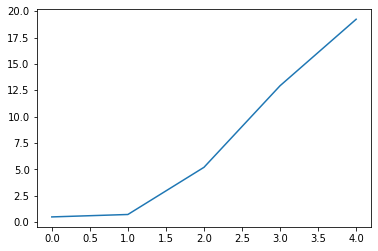

In [506]:
plt.plot([0.50,0.73,5.20,12.93,19.23])

In [486]:

f['spikes']['biophysical']['timestamps'].shape[0]/30,\
g['spikes']['biophysical']['timestamps'].shape[0]/30,\
h['spikes']['biophysical']['timestamps'].shape[0]/30,\
i['spikes']['biophysical']['timestamps'].shape[0]/30,\
j['spikes']['biophysical']['timestamps'].shape[0]/30

(0.5, 0.7333333333333333, 5.2, 12.933333333333334, 19.233333333333334)

In [478]:
h['spikes']['biophysical']['timestamps'].shape[0]/30

5.2

KeyError: "Unable to open object (object 'spikes' doesn't exist)"

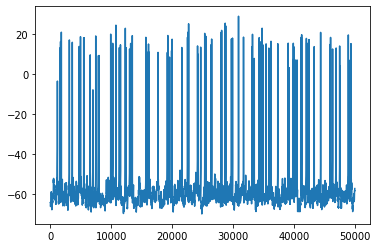

In [477]:
plt.plot(i['report']['biophysical']['data'][50000:100000,0])